# **Projet d’Optimisation – Breast Cancer (classification binaire) Dataset**

**Phase 1 : GD vs CG (manuels**)

**Phase 2 : SGD, RMSProp, Adam (manuels)**

**Phase 3 : OPTIMISATION NON LISSE (L1) – ISTA & FISTA**
- **Auteur** : *Jedou Mohamed Bebacar*  
- **Matricule** : *C30824*
- **Filière** : *Master SSD*  
- **Département** : *Mathématiques et Informatique*
- **Établissement** :*Université de Nouakchott*  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import time

plt.rcParams.update({'font.size': 12})
sns.set_style("whitegrid")

# ***Analyse descriptive et prétraitement***

🔍 Chargement du jeu de données 'Breast Cancer'...


/tmp/ipython-input-3202601242.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette=['red', 'blue'])


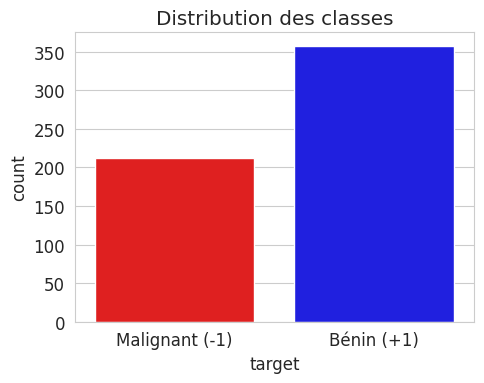

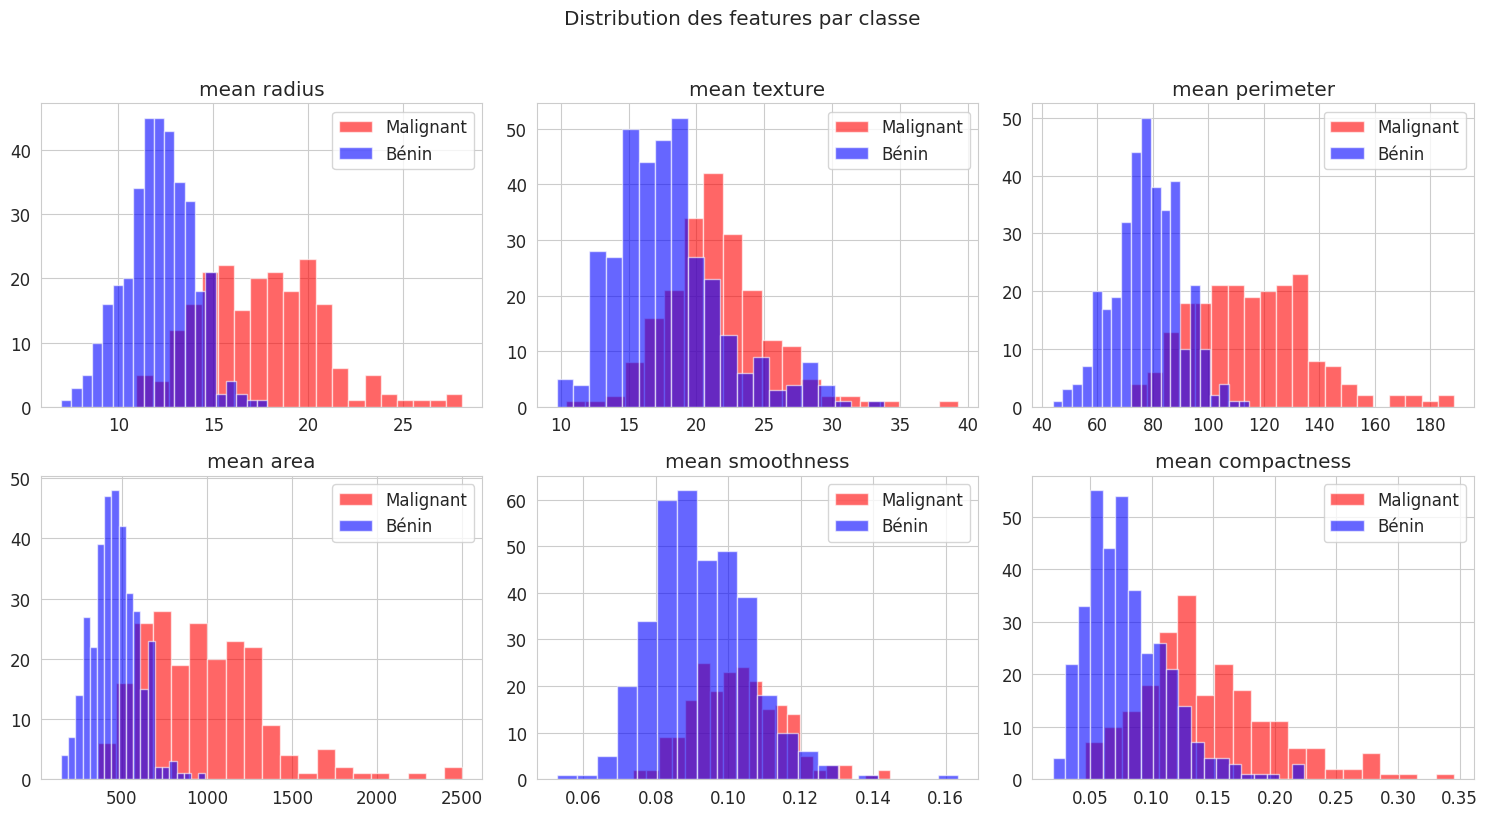

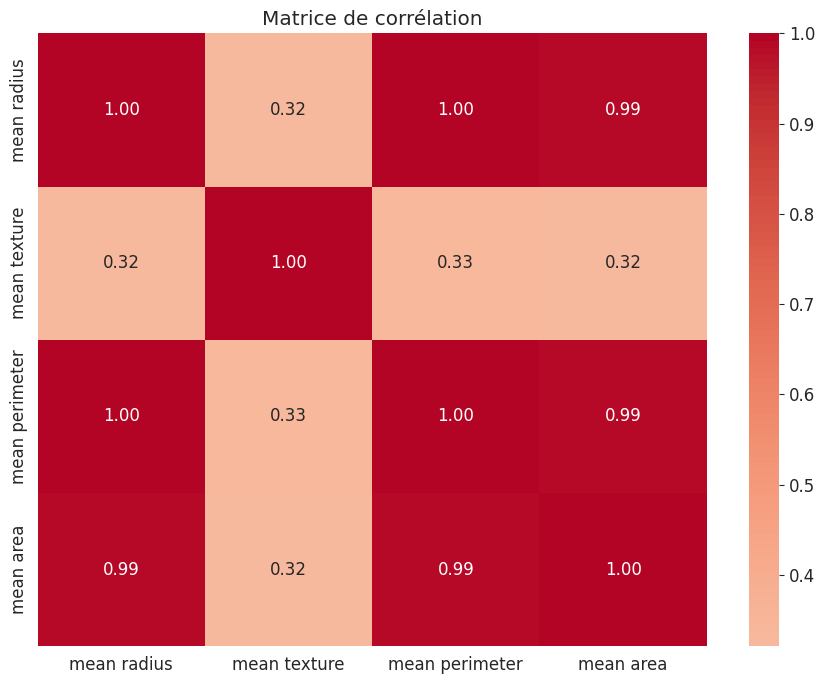


⚙️ Données standardisées | n=569, d=30, λ=0.01


In [3]:
# ------------------------------
# 2. CHARGEMENT ET ANALYSE DESCRIPTIVE
# ------------------------------
print("🔍 Chargement du jeu de données 'Breast Cancer'...")
data = load_breast_cancer()
X_raw = data.data
y_raw = data.target
feature_names = data.feature_names

# Conversion en {-1, +1}
y = 2 * y_raw - 1
df = pd.DataFrame(X_raw, columns=feature_names)
df['target'] = y

# Distribution des classes
plt.figure(figsize=(5, 4))
sns.countplot(x='target', data=df, palette=['red', 'blue'])
plt.xticks(ticks=[0, 1], labels=['Malignant (-1)', 'Bénin (+1)'])
plt.title('Distribution des classes')
plt.tight_layout()
plt.show()

# Histogrammes (6 features représentatives)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
features_to_plot = ['mean radius', 'mean texture', 'mean perimeter',
                    'mean area', 'mean smoothness', 'mean compactness']
for i, feat in enumerate(features_to_plot):
    ax = axes[i//3, i%3]
    for label, color in [(-1, 'red'), (1, 'blue')]:
        subset = df[df['target'] == label][feat]
        ax.hist(subset, bins=20, alpha=0.6, label=f"{'Malignant' if label==-1 else 'Bénin'}", color=color)
    ax.set_title(f'{feat}')
    ax.legend()
plt.suptitle('Distribution des features par classe', y=1.02)
plt.tight_layout()
plt.show()

# Matrice de corrélation
plt.figure(figsize=(9, 7))
subset = ['mean radius', 'mean texture', 'mean perimeter', 'mean area']
corr = df[subset].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matrice de corrélation')
plt.tight_layout()
plt.show()

# ------------------------------
# 3. PRÉTRAITEMENT
# ------------------------------
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)
n, d = X.shape
lambda_reg = 1e-2

print(f"\n⚙️ Données standardisées | n={n}, d={d}, λ={lambda_reg}")

In [4]:
# ------------------------------
# 4. FONCTIONS OBJECTIF ET GRADIENT
# ------------------------------
def sigmoid(t):
    t = np.clip(t, -500, 500)
    return 1.0 / (1.0 + np.exp(-t))

def F(w, X, y, lam):
    z = y * (X @ w)
    loss = np.mean(np.logaddexp(0, -z))
    reg = 0.5 * lam * np.dot(w, w)
    return loss + reg

def grad_F(w, X, y, lam):
    z = y * (X @ w)
    sigma = sigmoid(-z)
    return -(X.T @ (y * sigma)) / n + lam * w

def grad_F_i(w, x_i, y_i, lam):
    z = y_i * (x_i @ w)
    sigma = sigmoid(-z)
    grad_loss = -y_i * x_i * sigma
    grad_reg = lam * w
    return grad_loss + grad_reg


# ***PHASE 1 : GD ET CG MANUELS***

In [5]:
# Constante de Lipschitz
norm_X = np.linalg.norm(X, ord=2)
L = (norm_X**2) / (4 * n) + lambda_reg
alpha_gd = 1.0 / L

# Descente de Gradient
def descente_gradient(w0, X, y, lam, alpha, max_iter=2000, tol=1e-6):
    w = w0.copy()
    losses = []
    for k in range(max_iter):
        g = grad_F(w, X, y, lam)
        loss = F(w, X, y, lam)
        losses.append(loss)
        if np.linalg.norm(g) < tol:
            break
        w -= alpha * g
    return w, losses

# Gradient Conjugué (Polak-Ribière + backtracking)
def gradient_conjugue(w0, X, y, lam, max_iter=2000, tol=1e-6):
    w = w0.copy()
    g = grad_F(w, X, y, lam)
    d = -g
    losses = [F(w, X, y, lam)]

    for k in range(max_iter):
        if np.linalg.norm(g) < tol:
            break

        # Backtracking line search
        alpha = 1.0
        c = 1e-4
        rho = 0.5
        while True:
            w_new = w + alpha * d
            f_new = F(w_new, X, y, lam)
            if f_new <= losses[-1] + c * alpha * np.dot(g, d):
                break
            alpha *= rho
            if alpha < 1e-8:
                break

        w_new = w + alpha * d
        g_new = grad_F(w_new, X, y, lam)
        beta_pr = np.dot(g_new, g_new - g) / (np.dot(g, g) + 1e-12)
        beta_pr = max(beta_pr, 0)
        d = -g_new + beta_pr * d
        w, g = w_new, g_new
        losses.append(F(w, X, y, lam))

    return w, losses

w0 = np.zeros(d)
w_gd, losses_gd = descente_gradient(w0, X, y, lambda_reg, alpha_gd)
w_cg, losses_cg = gradient_conjugue(w0, X, y, lambda_reg)

print(f" GD terminée en {len(losses_gd)} itérations.")
print(f" CG terminée en {len(losses_cg)} itérations.")


 GD terminée en 2000 itérations.
 CG terminée en 707 itérations.


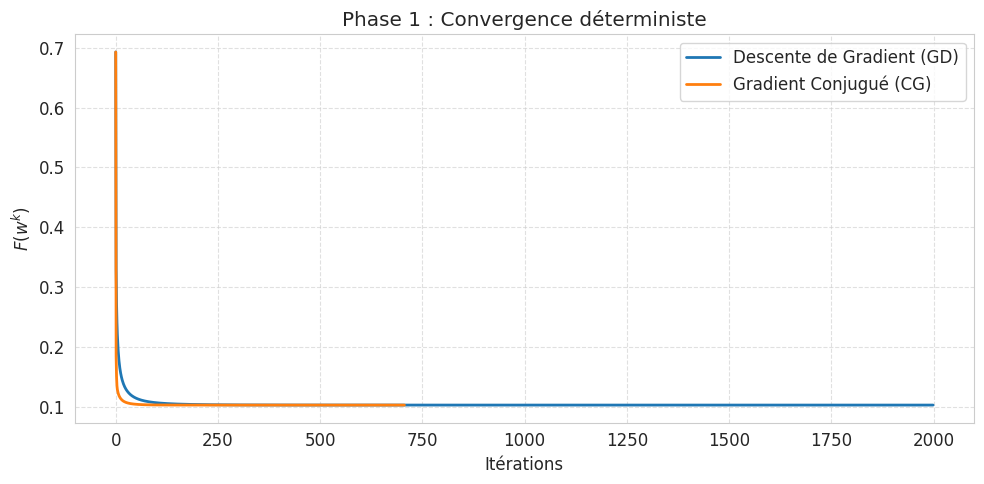

In [6]:
# Convergence déterministe (GD vs CG)
plt.figure(figsize=(10, 5))
plt.plot(losses_gd, label='Descente de Gradient (GD)', linewidth=2)
plt.plot(losses_cg, label='Gradient Conjugué (CG)', linewidth=2)
plt.xlabel('Itérations')
plt.ylabel(r'$F(w^k)$')
plt.title('Phase 1 : Convergence déterministe')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ***PHASE 2 : MÉTHODES STOCHASTIQUES***

In [7]:
# SGD à pas fixe
def sgd_fixed(w0, X, y, lam, alpha, epochs=100):
    n, d = X.shape
    w = w0.copy()
    losses = []
    for epoch in range(epochs):
        idx = np.random.permutation(n)
        for i in idx:
            g = grad_F_i(w, X[i], y[i], lam)
            w -= alpha * g
        losses.append(F(w, X, y, lam))
    return w, losses

# SGD à pas décroissant
def sgd_decaying(w0, X, y, lam, alpha0, beta=1.0, epochs=100):
    n, d = X.shape
    w = w0.copy()
    losses = []
    k = 0
    for epoch in range(epochs):
        idx = np.random.permutation(n)
        for i in idx:
            alpha = alpha0 / (1.0 + beta * k)
            g = grad_F_i(w, X[i], y[i], lam)
            w -= alpha * g
            k += 1
        losses.append(F(w, X, y, lam))
    return w, losses

# RMSProp
def rmsprop(w0, X, y, lam, alpha=0.001, rho=0.9, eps=1e-8, epochs=100):
    n, d = X.shape
    w = w0.copy()
    v = np.zeros(d)
    losses = []
    for epoch in range(epochs):
        idx = np.random.permutation(n)
        for i in idx:
            g = grad_F_i(w, X[i], y[i], lam)
            v = rho * v + (1 - rho) * g**2
            w -= alpha * g / (np.sqrt(v) + eps)
        losses.append(F(w, X, y, lam))
    return w, losses

# Adam
def adam(w0, X, y, lam, alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-8, epochs=100):
    n, d = X.shape
    w = w0.copy()
    m = np.zeros(d)
    v = np.zeros(d)
    losses = []
    t = 0
    for epoch in range(epochs):
        idx = np.random.permutation(n)
        for i in idx:
            t += 1
            g = grad_F_i(w, X[i], y[i], lam)
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * g**2
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            w -= alpha * m_hat / (np.sqrt(v_hat) + eps)
        losses.append(F(w, X, y, lam))
    return w, losses

# Exécution des méthodes stochastiques
np.random.seed(42)
_, losses_sgd_fixed = sgd_fixed(w0, X, y, lambda_reg, alpha=0.1, epochs=50)

np.random.seed(42)
_, losses_sgd_decay = sgd_decaying(w0, X, y, lambda_reg, alpha0=1.0, beta=1.0, epochs=50)

np.random.seed(42)
_, losses_rmsprop = rmsprop(w0, X, y, lambda_reg, alpha=0.01, epochs=50)

np.random.seed(42)
_, losses_adam = adam(w0, X, y, lambda_reg, alpha=0.01, epochs=50)

print(" Méthodes stochastiques terminées.")


 Méthodes stochastiques terminées.


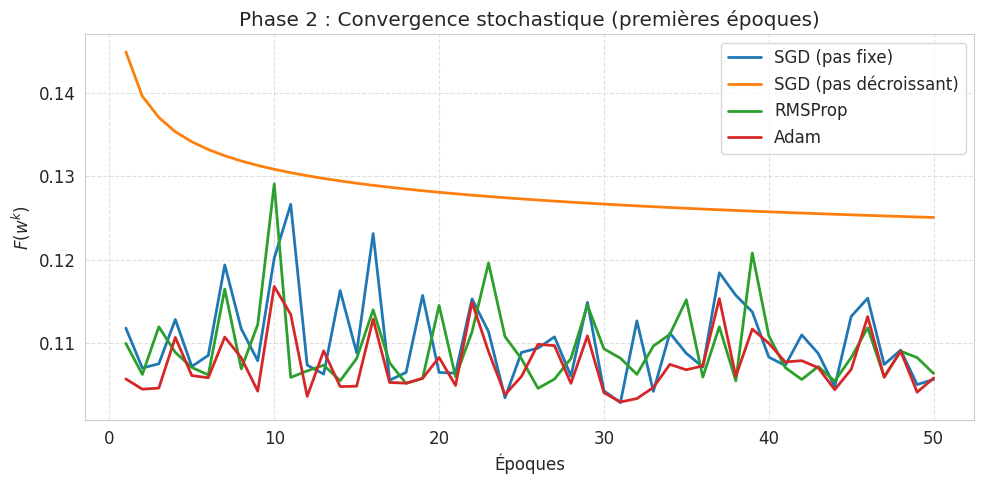

In [8]:
#Convergence stochastique (premières époques)
plt.figure(figsize=(10, 5))
epochs = np.arange(1, 51)
plt.plot(epochs, losses_sgd_fixed, label='SGD (pas fixe)', linewidth=2)
plt.plot(epochs, losses_sgd_decay, label='SGD (pas décroissant)', linewidth=2)
plt.plot(epochs, losses_rmsprop, label='RMSProp', linewidth=2)
plt.plot(epochs, losses_adam, label='Adam', linewidth=2)
plt.xlabel('Époques')
plt.ylabel(r'$F(w^k)$')
plt.title('Phase 2 : Convergence stochastique (premières époques)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ***Phase 3 : Optimisation non lisse (L1) – ISTA & FISTA***

In [9]:
# Nouveau paramètre de régularisation L1
lambda_l1 = 1e-2

# Fonctions spécifiques à la perte logistique (sans régularisation)
def f_logistic(w, X, y):
    """Perte logistique seule (partie lisse)."""
    z = y * (X @ w)
    return np.mean(np.logaddexp(0, -z))

def grad_f(w, X, y):
    """Gradient de la perte logistique seule."""
    z = y * (X @ w)
    sigma = sigmoid(-z)
    return -(X.T @ (y * sigma)) / len(y)

def soft_threshold(v, theta):
    """Opérateur proximal de la norme L1 (seuil doux)."""
    return np.sign(v) * np.maximum(np.abs(v) - theta, 0.0)

# Constante de Lipschitz pour la partie lisse f (sans λ)
L_f = (norm_X**2) / (4 * n)
alpha_ista = 1.0 / L_f  # pas optimal pour ISTA/FISTA

# ISTA (Iterative Soft-Thresholding Algorithm)
def ista(w0, X, y, lam, alpha, max_iter=500):
    w = w0.copy()
    losses = []
    for _ in range(max_iter):
        g = grad_f(w, X, y)
        w = soft_threshold(w - alpha * g, alpha * lam)
        loss = f_logistic(w, X, y) + lam * np.linalg.norm(w, 1)
        losses.append(loss)
    return w, losses

# FISTA (Fast ISTA)
def fista(w0, X, y, lam, alpha, max_iter=500):
    w = w0.copy()
    y_k = w0.copy()
    t = 1.0
    losses = []
    for _ in range(max_iter):
        g = grad_f(y_k, X, y)
        w_new = soft_threshold(y_k - alpha * g, alpha * lam)
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y_k = w_new + ((t - 1) / t_new) * (w_new - w)
        loss = f_logistic(w_new, X, y) + lam * np.linalg.norm(w_new, 1)
        losses.append(loss)
        w, t = w_new, t_new
    return w, losses

# Exécution de ISTA et FISTA
w0_phase3 = np.zeros(d)
w_ista, losses_ista = ista(w0_phase3, X, y, lambda_l1, alpha_ista)
w_fista, losses_fista = fista(w0_phase3, X, y, lambda_l1, alpha_ista)

print(f"ISTA terminée en {len(losses_ista)} itérations.")
print(f"FISTA terminée en {len(losses_fista)} itérations.")

ISTA terminée en 500 itérations.
FISTA terminée en 500 itérations.


In [10]:
# Analyse de la parcimonie : nombre de coefficients nuls vs λ
lambdas = np.logspace(-4, 0, 20)  # de 1e-4 à 1
zeros_ista = []
for lam in lambdas:
    w, _ = ista(w0_phase3, X, y, lam, alpha_ista, max_iter=300)
    zeros_ista.append(np.sum(np.abs(w) < 1e-5))  # seuil numérique

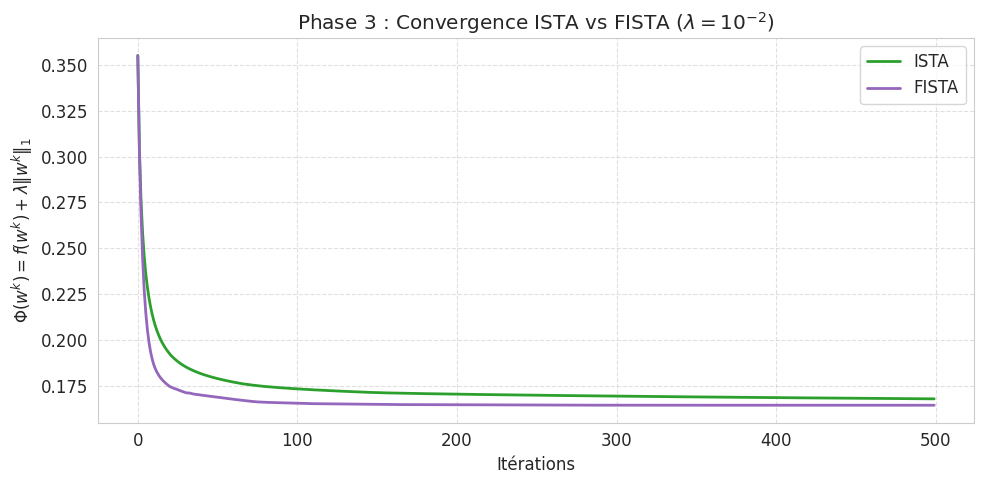

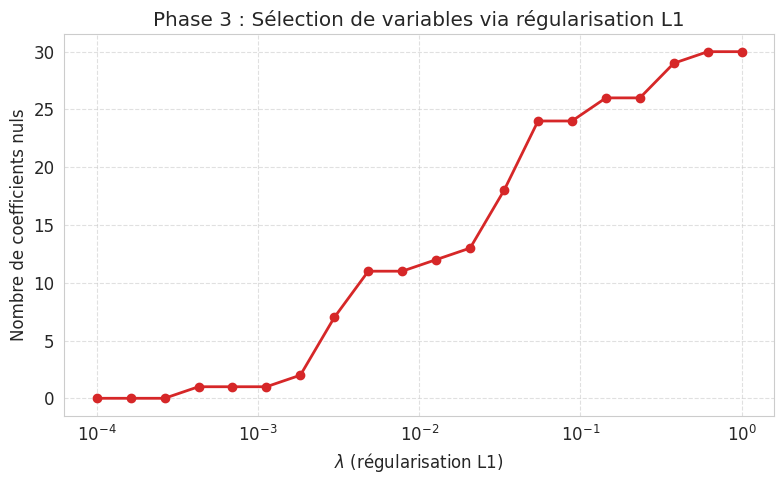

In [11]:
# Convergence ISTA vs FISTA
plt.figure(figsize=(10, 5))
plt.plot(losses_ista, label='ISTA', linewidth=2, color='tab:green')
plt.plot(losses_fista, label='FISTA', linewidth=2, color='tab:purple')
plt.xlabel('Itérations')
plt.ylabel(r'$\Phi(w^k) = f(w^k) + \lambda \|w^k\|_1$')
plt.title(r'Phase 3 : Convergence ISTA vs FISTA ($\lambda = 10^{-2}$)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Parcimonie en fonction de λ
plt.figure(figsize=(8, 5))
plt.semilogx(lambdas, zeros_ista, 'o-', linewidth=2, markersize=6, color='tab:red')
plt.xlabel(r'$\lambda$ (régularisation L1)')
plt.ylabel('Nombre de coefficients nuls')
plt.title('Phase 3 : Sélection de variables via régularisation L1')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()